<a href="https://colab.research.google.com/github/s192624/WindPower_forecasting_Klim/blob/main/LSTM_Klim_exogenous_with_direction_and_T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Forecast of power 3 hours ahead based on LSTM with knowledge of wind speed, wind direction and temperature - with use of 7 days slices**

As a first step, an LSTM network is implemented considering only the power time series. The results can be compared with those of the AR(4) model fitted to the data in Matlab: 95% confidence intervals:

*   1h ahead: [-3.17:3.17]
*   2h ahead: [-4.73:4.73]
*   3h ahead: [-5.76:5.76]

And the LSTM network with slices:

*   1h ahead: [-3.12:3.12]
*   2h ahead: [-4.67:4.67]
*   3h ahead: [-5.72:5.72]



In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics as stat
from random import shuffle

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn.parameter import Parameter
import torch.nn.init as init
import torch.nn.functional as F

In [34]:
# Load the data and extract colums
file = '/content/drive/MyDrive/Colab Notebooks/Time series/LSTM_Klim/cex4WindDataInterpolated.csv'
data = pd.read_csv(file)
t = data.iloc[:,0].values
p = data.iloc[:,2].values
ws1 = data.iloc[:,3].values
ws2 = data.iloc[:,6].values
ws3 = data.iloc[:,9].values
wd1 = data.iloc[:,4].values
wd2 = data.iloc[:,7].values
wd3 = data.iloc[:,10].values
T1 = data.iloc[:,5].values
T2 = data.iloc[:,8].values
T3 = data.iloc[:,11].values

In [35]:
# Normalize the data except wind direction which will be one hot encoded
p_mean = np.nanmean(p)
p_std = np.nanstd(p)
ws_mean = np.nanmean(ws1)
ws_std = np.nanstd(ws1)
T_mean = np.nanmean(T1)
T_std = np.nanstd(T1)

p = (p-p_mean)/p_std
ws1 = (ws1-ws_mean)/ws_std
ws2 = (ws2-ws_mean)/ws_std
ws3 = (ws3-ws_mean)/ws_std
T1 = (T1-T_mean)/T_std
T2 = (T2-T_mean)/T_std
T3 = (T3-T_mean)/T_std

In [36]:
# Loop to keep sequences of valid power, wind speed and wind direction
p_valid, ws1_valid, ws2_valid, ws3_valid, wd1_valid, wd2_valid, wd3_valid  = [],[],[],[],[],[],[]
T1_valid, T2_valid, T3_valid = [],[],[]
current_seq_p, current_seq_ws1, current_seq_ws2 , current_seq_ws3,  = [],[],[],[]
current_seq_wd1, current_seq_wd2 , current_seq_wd3, current_seq_T1, current_seq_T2 , current_seq_T3 = [],[],[],[],[],[] 

nan = 1             # 1 if former value is nan

for i in range(len(p)):

  # Check if current value is nan
  if np.isnan(p[i]) or np.isnan(ws1[i]) or np.isnan(wd1[i]) or np.isnan(T1[i]):
    # If former value not nan, store former sequence and create a new one 
    if nan == 0:
      p_valid.append(current_seq_p)
      ws1_valid.append(current_seq_ws1)
      ws2_valid.append(current_seq_ws2)
      ws3_valid.append(current_seq_ws3)
      wd1_valid.append(current_seq_wd1)
      wd2_valid.append(current_seq_wd2)
      wd3_valid.append(current_seq_wd3)
      T1_valid.append(current_seq_T1)
      T2_valid.append(current_seq_T2)
      T3_valid.append(current_seq_T3)
      current_seq_p, current_seq_ws1, current_seq_ws2 , current_seq_ws3,  = [],[],[],[]
      current_seq_wd1, current_seq_wd2 , current_seq_wd3, current_seq_T1, current_seq_T2 , current_seq_T3 = [],[],[],[],[],[] 
    nan = 1

  # Else, store the value and state it is not nan
  else:
    current_seq_p.append([p[i]])
    current_seq_ws1.append([ws1[i]])
    current_seq_ws2.append([ws2[i]])
    current_seq_ws3.append([ws3[i]])
    current_seq_wd1.append([wd1[i]])
    current_seq_wd2.append([wd2[i]])
    current_seq_wd3.append([wd3[i]])
    current_seq_T1.append([T1[i]])
    current_seq_T2.append([T2[i]])
    current_seq_T3.append([T3[i]])
    nan = 0

p_valid.append(current_seq_p)
ws1_valid.append(current_seq_ws1)
ws2_valid.append(current_seq_ws2)
ws3_valid.append(current_seq_ws3)
wd1_valid.append(current_seq_wd1)
wd2_valid.append(current_seq_wd2)
wd3_valid.append(current_seq_wd3)
T1_valid.append(current_seq_T1)
T2_valid.append(current_seq_T2)
T3_valid.append(current_seq_T3)

In [37]:
# Define slices of 168h power inputs and corresponding targets one 1h ahead
# Also define forecasts of wind speed, wind direction and temperature
p_inputs, p_targets, p_targets2h, p_targets3h = [],[],[],[]
ws1_forecast, ws2_forecast, ws3_forecast = [],[],[]
wd1_forecast, wd2_forecast, wd3_forecast = [],[],[]
T1_forecast, T2_forecast, T3_forecast = [],[],[]

for seq in range(len(p_valid)):
  for i in range(len(p_valid[seq])-170):
    p_inputs.append(p_valid[seq][i:i+168])
    p_targets.append(p_valid[seq][i+168])
    p_targets2h.append(p_valid[seq][i+169])
    p_targets3h.append(p_valid[seq][i+170])
    ws1_forecast.append(ws1_valid[seq][i+168])
    ws2_forecast.append(ws2_valid[seq][i+168])
    ws3_forecast.append(ws3_valid[seq][i+168])
    wd1_forecast.append(wd1_valid[seq][i+168])
    wd2_forecast.append(wd2_valid[seq][i+168])
    wd3_forecast.append(wd3_valid[seq][i+168])
    T1_forecast.append(T1_valid[seq][i+168])
    T2_forecast.append(T2_valid[seq][i+168])
    T3_forecast.append(T3_valid[seq][i+168])

In [38]:
# One hot encode the wind directions
wd1_forecast_onehot = []
wd2_forecast_onehot = []
wd3_forecast_onehot = []

# For wd1
for i in range(len(wd1_forecast)):
  onehot = 12*[None]
  sector = np.floor(wd1_forecast[i][0]/30)
  for s in range(12):
    if sector == s:
      onehot[s] = 1
    else:
      onehot[s] = 0
  wd1_forecast_onehot.append(onehot)

# For wd2
for i in range(len(wd2_forecast)):
  onehot = 12*[None]
  sector = np.floor(wd2_forecast[i][0]/30)
  for s in range(12):
    if sector == s:
      onehot[s] = 1
    else:
      onehot[s] = 0
  wd2_forecast_onehot.append(onehot)

# For wd3
for i in range(len(wd3_forecast)):
  onehot = 12*[None]
  sector = np.floor(wd3_forecast[i][0]/30)
  for s in range(12):
    if sector == s:
      onehot[s] = 1
    else:
      onehot[s] = 0
  wd3_forecast_onehot.append(onehot) 

In [ ]:
# Shuffle the inputs and targets
l = list(zip(p_inputs,p_targets,p_targets2h,p_targets3h,ws1_forecast,ws2_forecast,ws3_forecast,
             wd1_forecast,wd2_forecast,wd3_forecast,T1_forecast,T2_forecast,T3_forecast))
shuffle(l)
p_inputs,p_targets,p_targets2h,p_targets3h,ws1_forecast,ws2_forecast,ws3_forecast,wd1_forecast,wd2_forecast,wd3_forecast,T1_forecast,T2_forecast,T3_forecast = zip(*l)

In [39]:
# Define an LSTM network

class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        self.lstm = nn.LSTM(input_size =1,hidden_size=128, batch_first = False)        
        self.ffnn_forecast1 = nn.Linear(in_features = 14, out_features = 512, bias = False)
        self.ffnn_forecast2 = nn.Linear(in_features = 512, out_features = 512, bias = False)
        
        # Output layer
        self.l_out = nn.Linear(in_features=512+128,
                            out_features=1,
                            bias=False)
        
    def forward(self, p_past, ws_forecast, wd_forecast, T_forecast):

        # RNN returns output
        x_rnn, (h, c) = self.lstm(p_past)
        
        # FNN on the wind speed forecast
        x_ffnn = elu(self.ffnn_forecast1(torch.cat((ws_forecast,wd_forecast,T_forecast),1))) # Concatenate on dim 1, being the features, 0 is the batch samples
        x_ffnn = elu(self.ffnn_forecast2(x_ffnn))

        # Output layer on the concatenate last rnn hidden state and ffnn result
        x = torch.cat((x_rnn[-1], x_ffnn), 1)  # Concatenate on dimension 1, 0 being the batch samples, 1 being the units
        x = self.l_out(x)
        
        return x

net = MyRecurrentNet()
print(net)

MyRecurrentNet(
  (lstm): LSTM(1, 128)
  (ffnn_forecast1): Linear(in_features=14, out_features=512, bias=False)
  (ffnn_forecast2): Linear(in_features=512, out_features=512, bias=False)
  (l_out): Linear(in_features=640, out_features=1, bias=False)
)


In [40]:
# Test of a dummy input of two sequences
dummy = torch.tensor(list([
                                [[1.0],[2.0],[3.0]],
                                [[4.0],[5.0],[6.0]]
                    ])).float()
dummy = torch.swapaxes(dummy,0,1) # The network uses the format (Seq, Batch, Features)
forecast_ws = torch.tensor([[1.0],[2.0]]).float()
forecast_wd = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).float()
forecast_T = torch.tensor([[270],[300]]).float()
net(dummy,forecast_ws,forecast_wd,forecast_T)

tensor([[ 9.3702],
        [10.4224]], grad_fn=<MmBackward>)

In [41]:
# Test the untrained network on two first sequences
net(torch.swapaxes(torch.Tensor([p_inputs[0],p_inputs[1]]),0,1),
    torch.Tensor([ws1_forecast[0],ws1_forecast[1]]),
    torch.Tensor([wd1_forecast_onehot[0],wd1_forecast_onehot[1]]),
    torch.Tensor([T1_forecast[0],T1_forecast[1]]),
    )

tensor([[-0.0532],
        [-0.0532]], grad_fn=<MmBackward>)

In [42]:
# Initialize the network
net = MyRecurrentNet()
# Convert to cuda if GPU available
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

# Define loss function and train parameters
criterion = nn.MSELoss(reduction='sum')    # Sum the squares but not perform the mean

# Adam gradient descent with learning rate decay
optimizer = optim.Adam(net.parameters(), lr=1e-4)
decayRate = 0.999
decay_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# Length of the training and batches
epochs = 40
batch_size = 32
num_batch = len(p_inputs)//batch_size

# Function to get the batch
get_batch = lambda i, size: range(i * size, (i + 1) * size)

Epoch 1, training RMSE: 2.74, CI: [-5.37:5.37]
Epoch 2, training RMSE: 1.99, CI: [-3.90:3.90]
Epoch 3, training RMSE: 1.73, CI: [-3.40:3.40]
Epoch 4, training RMSE: 1.62, CI: [-3.17:3.17]
Epoch 5, training RMSE: 1.57, CI: [-3.07:3.07]
Epoch 6, training RMSE: 1.55, CI: [-3.05:3.05]
Epoch 7, training RMSE: 1.55, CI: [-3.03:3.03]
Epoch 8, training RMSE: 1.54, CI: [-3.02:3.02]
Epoch 9, training RMSE: 1.54, CI: [-3.01:3.01]
Epoch 10, training RMSE: 1.53, CI: [-3.01:3.01]
Epoch 11, training RMSE: 1.53, CI: [-3.00:3.00]
Epoch 12, training RMSE: 1.53, CI: [-3.00:3.00]
Epoch 13, training RMSE: 1.53, CI: [-3.00:3.00]
Epoch 14, training RMSE: 1.53, CI: [-2.99:2.99]
Epoch 15, training RMSE: 1.53, CI: [-2.99:2.99]
Epoch 16, training RMSE: 1.52, CI: [-2.99:2.99]
Epoch 17, training RMSE: 1.52, CI: [-2.99:2.99]
Epoch 18, training RMSE: 1.52, CI: [-2.98:2.98]
Epoch 19, training RMSE: 1.52, CI: [-2.98:2.98]
Epoch 20, training RMSE: 1.52, CI: [-2.98:2.98]
Epoch 21, training RMSE: 1.52, CI: [-2.98:2.98]
E

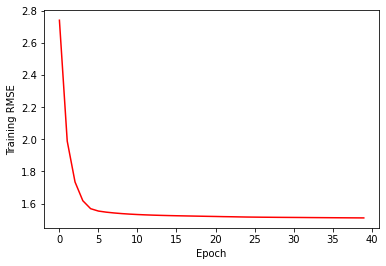

In [43]:
# Training

# Track loss
training_RMSE = []

# Loop over epochs
for i in range(epochs):

    epoch_training_loss = 0

    net.train()

    # For each sequence in training set
    for b in range(num_batch):

      batch_index = get_batch(b,batch_size)
                 
      # Convert to tensor and swap axes of inputs to get (seq, batch, features)
      inputs_past = torch.swapaxes(torch.Tensor(p_inputs)[batch_index],0,1)
      inputs_forecast_ws = torch.Tensor(ws1_forecast)[batch_index]
      inputs_forecast_wd = torch.Tensor(wd1_forecast_onehot)[batch_index]
      inputs_forecast_T = torch.Tensor(T1_forecast)[batch_index]
      targets = torch.Tensor(p_targets)[batch_index]

      # Convert to cuda to run on GPU
      if torch.cuda.is_available():
            inputs_past = Variable(inputs_past.cuda())
            inputs_forecast_ws = Variable(inputs_forecast_ws.cuda())
            inputs_forecast_wd = Variable(inputs_forecast_wd.cuda())
            inputs_forecast_T = Variable(inputs_forecast_T.cuda())
            targets = Variable(targets.cuda())

      # Forward pass
      outputs = net(inputs_past,inputs_forecast_ws,inputs_forecast_wd,inputs_forecast_T)
          
      # Compute loss
      loss = criterion(outputs, targets)
          
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
          
      # Update loss
      if torch.cuda.is_available():
        epoch_training_loss += loss.cpu().detach().numpy()
      else:
        epoch_training_loss += loss.detach().numpy()
    
    # Save loss for plot
    epoch_RMSE = np.sqrt(epoch_training_loss/(num_batch*batch_size))
    training_RMSE.append(epoch_RMSE*p_std)  # Storing epoch RMSE and removing normalization to evaluate RMSE

    # Compute confidence interval
    CI = [norm.ppf(0.025)*training_RMSE[-1],norm.ppf(0.975)*training_RMSE[-1]]

    # Print loss every 10 epochs
    if i % 1 == 0:
        print('Epoch %d, training RMSE: %.2f, CI: [%.2f:%.2f]' % (i+1,training_RMSE[-1],CI[0],CI[1]))

    # Apply learning rate decay
    decay_scheduler.step()

# Plot training loss
epoch = np.arange(len(training_RMSE))
plt.figure()
plt.plot(epoch, training_RMSE, 'r')
plt.xlabel('Epoch'), plt.ylabel('Training RMSE')
plt.show()

In [ ]:
# Forecasting 1, 2 and 3 hours ahead

# Back on CPU
net.to('cpu')

# Store predictions and errors
pred_1h = []
err_1h = []
pred_2h = []
err_2h = []
pred_3h = []
err_3h = []

# Loop over the sequences of valid data and ws forecast
for seq in range(len(p_inputs)):

    # Define past value for the 1h forecast
    past = p_inputs[seq]
    ws_forecast = ws1_forecast[seq]
    wd_forecast = wd1_forecast_onehot[seq]
    T_forecast = T1_forecast[seq]
  
    # Take output of first and only sequence, last value
    pred_1h.append(net(torch.swapaxes(torch.Tensor([past]),0,1),torch.Tensor([ws_forecast]),torch.Tensor([wd_forecast]),torch.Tensor([T_forecast])).item())
    err_1h.append(pred_1h[-1]-p_targets[seq][0])

    # Repeat with prediction 2 hours ahead actualizing first the past values
    past.append([pred_1h[-1]])
    ws_forecast = ws2_forecast[seq+1]   #Take the forecast for 2h ahead (seq+1) made at least 2h before (ws2)
    wd_forecast = wd2_forecast_onehot[seq+1]
    T_forecast = T2_forecast[seq+1]
    pred_2h.append(net(torch.swapaxes(torch.Tensor([past]),0,1),torch.Tensor([ws_forecast]),torch.Tensor([wd_forecast]),torch.Tensor([T_forecast])).item())
    err_2h.append(pred_2h[-1]-p_targets2h[seq][0])

    # Repeat with prediction 3 hours ahead
    past.append([pred_2h[-1]])
    ws_forecast = ws3_forecast[seq+2]
    wd_forecast = wd3_forecast_onehot[seq+2]
    T_forecast = T3_forecast[seq+2]
    pred_3h.append(net(torch.swapaxes(torch.Tensor([past]),0,1),torch.Tensor([ws_forecast]),torch.Tensor([wd_forecast]),torch.Tensor([T_forecast])).item())
    err_3h.append(pred_3h[-1]-p_targets3h[seq][0])

    if seq % 1000 == 0:
      print('progress %.2f %%, RMSE 1h: %.2f, RMSE 2h: %.2f, RMSE 3h: %.2f'
           % (100*(seq+1)/len(p_inputs),
            p_std*np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h)))),
            p_std*np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h)))), 
            p_std*np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h)))))
           )

progress 0.00 %, RMSE 1h: 0.35, RMSE 2h: 0.33, RMSE 3h: 0.34
progress 2.87 %, RMSE 1h: 1.96, RMSE 2h: 2.71, RMSE 3h: 3.05
progress 5.73 %, RMSE 1h: 1.79, RMSE 2h: 2.46, RMSE 3h: 2.79
progress 8.59 %, RMSE 1h: 1.70, RMSE 2h: 2.42, RMSE 3h: 2.80
progress 11.46 %, RMSE 1h: 1.66, RMSE 2h: 2.39, RMSE 3h: 2.77
progress 14.32 %, RMSE 1h: 1.58, RMSE 2h: 2.26, RMSE 3h: 2.62
progress 17.18 %, RMSE 1h: 1.51, RMSE 2h: 2.15, RMSE 3h: 2.48
progress 20.04 %, RMSE 1h: 1.52, RMSE 2h: 2.18, RMSE 3h: 2.52
progress 22.91 %, RMSE 1h: 1.61, RMSE 2h: 2.29, RMSE 3h: 2.63
progress 25.77 %, RMSE 1h: 1.66, RMSE 2h: 2.36, RMSE 3h: 2.73
progress 28.63 %, RMSE 1h: 1.67, RMSE 2h: 2.38, RMSE 3h: 2.75
progress 31.50 %, RMSE 1h: 1.62, RMSE 2h: 2.32, RMSE 3h: 2.68
progress 34.36 %, RMSE 1h: 1.62, RMSE 2h: 2.32, RMSE 3h: 2.69
progress 37.22 %, RMSE 1h: 1.59, RMSE 2h: 2.28, RMSE 3h: 2.64
progress 40.09 %, RMSE 1h: 1.58, RMSE 2h: 2.26, RMSE 3h: 2.62
progress 42.95 %, RMSE 1h: 1.59, RMSE 2h: 2.27, RMSE 3h: 2.62
progress 45.

In [ ]:
# Estimation of confidence intervals:
RMSE_1h = np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))
RMSE_2h = np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))
RMSE_3h = np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))
CI_1h = [norm.ppf(0.025)*RMSE_1h,norm.ppf(0.975)*RMSE_1h]
CI_2h = [norm.ppf(0.025)*RMSE_2h,norm.ppf(0.975)*RMSE_2h]
CI_3h = [norm.ppf(0.025)*RMSE_3h,norm.ppf(0.975)*RMSE_3h]
print(f'Confidence interval 1h: {CI_1h}')
print(f'Confidence interval 2h: {CI_2h}')
print(f'Confidence interval 3h: {CI_3h}')

In [ ]:
# Save the model
torch.save(net.state_dict(),
           '/content/drive/MyDrive/Colab Notebooks/Time series/LSTM_Klim/LSTM_power_ws_wd_T.pth')